# modelling sea level from temperature

we have 2 data sets:
1. temperature data
2. sea level data

we have a model defined as 

$$
    \begin{align*}
    S_{eq} &= aT+b \\ 
    \frac{\partial S_{eq}}{\partial t} &= \frac{S-S_{eq}}{\tau}
    \end{align*}
$$

---

We want to predict the sea level from temperature such that it is consistent with the measured sea level data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize



In [2]:
df_T_forecast = pd.read_csv('data/T_forecast_auto_arima.csv', index_col=0)
df_T_forecast

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,Annual_uncertainty
2025,1.091711,1.069857,1.052720,1.039308,1.028838,1.020691,1.014379,1.009517,1.005800,1.002987,1.000888,0.999354,1.028004,0.028585
2026,0.998264,0.997527,0.997067,0.996827,0.996760,0.996830,0.997008,0.997272,0.997603,0.997987,0.998413,0.998873,0.997536,0.000675
2027,0.999359,0.999866,1.000389,1.000924,1.001471,1.002025,1.002585,1.003151,1.003720,1.004293,1.004868,1.005445,1.002341,0.001918
2028,1.006024,1.006604,1.007185,1.007767,1.008349,1.008931,1.009515,1.010098,1.010682,1.011265,1.011849,1.012433,1.009225,0.002012
2029,1.013018,1.013602,1.014186,1.014770,1.015355,1.015939,1.016523,1.017108,1.017692,1.018277,1.018861,1.019446,1.016231,0.002017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,1.651283,1.651867,1.652452,1.653036,1.653621,1.654205,1.654790,1.655374,1.655959,1.656543,1.657128,1.657712,1.654497,0.002018
2121,1.658297,1.658881,1.659466,1.660050,1.660635,1.661219,1.661803,1.662388,1.662972,1.663557,1.664141,1.664726,1.661511,0.002018
2122,1.665310,1.665895,1.666479,1.667064,1.667648,1.668233,1.668817,1.669402,1.669986,1.670571,1.671155,1.671740,1.668525,0.002018
2123,1.672324,1.672909,1.673493,1.674078,1.674662,1.675247,1.675831,1.676416,1.677000,1.677585,1.678169,1.678754,1.675539,0.002018


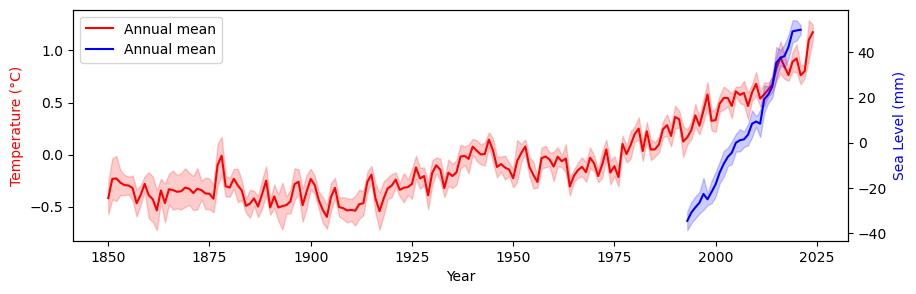

In [3]:
# load data

df_T = pd.read_csv('data/processed_temperature_data.csv', index_col=0)

df_S = pd.read_csv('data/processed_sea_level_data.csv', index_col=0)

def plot_data(df_T, df_S):
    # plot data
    fig, ax = plt.subplots(figsize=(10, 3))
    ax2 = ax.twinx()

    # plt.plot(df_T.index, df_T['Annual'], label='Annual mean')
    # plt.plot(df_S.index, df_S['GMSL_noGIA'], label='Annual mean')
    ax.plot(df_T.index, df_T['Annual'], label='Annual mean', color='red')
    ax2.plot(df_S.index, df_S['GMSL_noGIA'], label='Annual mean', color='blue')

    # show uncertainty
    ax.fill_between(df_T.index, df_T['Annual'] - df_T['Annual_uncertainty'], df_T['Annual'] + df_T['Annual_uncertainty'], alpha=0.2, color='red')
    ax2.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], alpha=0.2, color='blue')

    # combine legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='best')

    # add ax labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Sea Level (mm)', color='blue')

    plt.show()

plot_data(df_T, df_S)


In [4]:
# stack df_T with forecast
df_T = pd.concat([df_T, df_T_forecast])
df_T


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,Annual_uncertainty
1850.0,-0.675000,-0.333000,-0.591000,-0.589000,-0.509000,-0.344000,-0.160000,-0.208000,-0.385000,-0.533000,-0.283000,-0.404000,-0.418000,0.155349
1851.0,-0.201000,-0.469000,-0.646000,-0.542000,-0.198000,-0.137000,-0.097000,-0.102000,-0.091000,-0.008000,-0.082000,-0.228000,-0.233000,0.196316
1852.0,-0.375000,-0.477000,-0.560000,-0.585000,-0.127000,-0.084000,0.005000,-0.136000,-0.002000,-0.172000,-0.305000,0.065000,-0.229000,0.216206
1853.0,-0.233000,-0.404000,-0.280000,-0.386000,-0.268000,-0.142000,-0.083000,-0.057000,-0.250000,-0.392000,-0.411000,-0.337000,-0.270000,0.118765
1854.0,-0.381000,-0.361000,-0.243000,-0.334000,-0.289000,-0.299000,-0.179000,-0.239000,-0.217000,-0.095000,-0.410000,-0.450000,-0.292000,0.098235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120.0,1.651283,1.651867,1.652452,1.653036,1.653621,1.654205,1.654790,1.655374,1.655959,1.656543,1.657128,1.657712,1.654497,0.002018
2121.0,1.658297,1.658881,1.659466,1.660050,1.660635,1.661219,1.661803,1.662388,1.662972,1.663557,1.664141,1.664726,1.661511,0.002018
2122.0,1.665310,1.665895,1.666479,1.667064,1.667648,1.668233,1.668817,1.669402,1.669986,1.670571,1.671155,1.671740,1.668525,0.002018
2123.0,1.672324,1.672909,1.673493,1.674078,1.674662,1.675247,1.675831,1.676416,1.677000,1.677585,1.678169,1.678754,1.675539,0.002018


In [5]:
# modelling
def dS_dt(S, S_eq, tau):
    return (S_eq - S) / tau


time = df_T.index


## initialize T
T = df_T.Annual.values

## initialize parameters
a =0.5
b =1.5
S_0 = 1.
tau = 10.
dt = 0.1

def get_S(T, a, b, S_0, tau):


    ## now lets set up S
    S_eq = a*T + b  # equilibrium sea level

    ## initialize S
    S = np.zeros(len(T))
    S[0] = S_0
    for i in range(1, len(T)):  # fill in S over time using forward euler
        S[i] = S[i-1] + dS_dt(S[i-1], S_eq[i-1], tau)*dt

    return S


def plot_T_S(time, T, S, df_S):

    # plot T and S over time on twinx plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()

    ax.plot(time, T, color='red', label='Temperature', alpha=0.5)
    ax2.plot(time, S, color='blue', label='Sea Level (predicted)', alpha=0.5)

    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Temperature Anomaly (°C)', color='red')
    ax2.set_ylabel('Sea Level (mm)', color='blue')

    ax.tick_params(axis='y', colors='red')
    ax2.tick_params(axis='y', colors='blue')


    ax2.plot(df_S.index, df_S['GMSL_noGIA'], label='Sea Level (measured)', color='green')

    # show uncertainty
    ax2.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], alpha=0.2, color='green')


    plt.title('Temperature Anomaly and Sea Level over Time')
    # combine legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='best')
    plt.show()

# plot_T_S(time, T, S, df_S)

S = get_S(T, a, b, S_0, tau)

def get_error(df_S, S):
    error = np.sqrt(np.sum((df_S.GMSL_noGIA.values - S[-len(df_S)-100:-100])**2))
    return error

# Define the objective function for minimization
def objective(params):
    a, b, S_0, tau = params
    S = get_S(T, a, b, S_0, tau,)
    return get_error(df_S, S)

# Initial guess for the parameters a and b
initial_guess = [0.5, 1.5, -1., 54.,]

# Perform the minimization
result = minimize(objective, initial_guess, method='Nelder-Mead', 
                   bounds=[(0, 2), (0, 5), (-200, 200), (20, 5000),]
                  )

# Extract the optimized parameters
a_opt, b_opt, S_0, tau = result.x

# Print the optimized parameters
print(f"Optimized a: {a_opt}, Optimized b: {b_opt}, Optimized S_0: {S_0}, Optimized tau: {tau}")



Optimized a: 2.0, Optimized b: 5.0, Optimized S_0: 3.814156276261847, Optimized tau: 20.0


In [6]:
print(f"Optimized a: {a_opt}, Optimized b: {b_opt}, Optimized S_0: {S_0}, Optimized tau: {tau}, Optimized dt: {dt}")

Optimized a: 2.0, Optimized b: 5.0, Optimized S_0: 3.814156276261847, Optimized tau: 20.0, Optimized dt: 0.1


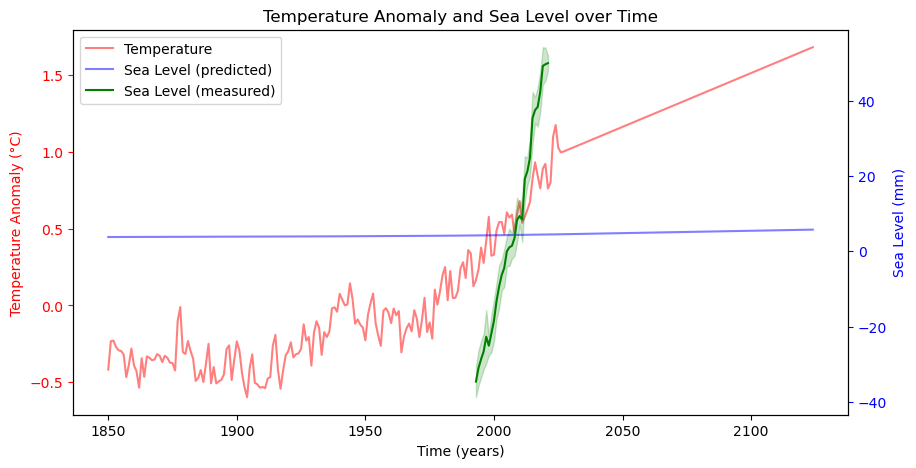

Optimized error: 141.57113182503207


In [7]:
# now plot with optimal para
S_opt = get_S(T, a_opt, b_opt, S_0, tau)
plot_T_S(time, T, S_opt, df_S)

error_opt = get_error(df_S, S_opt)
print(f"Optimized error: {error_opt}")



# MCMC

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import theano
import theano.tensor as tt

# Assume df_T and df_S are your dataframes with temperature and sea level data
# df_T should have an index of time and a column 'Annual' for temperature anomalies
# df_S should have an index of time and columns 'GMSL_noGIA' for sea level and 'uncertainty' for measurement errors

# Extract time and temperature data
time = df_T.index.values
T = df_T['Annual'].values

# Define Theano shared variables for T
T_shared = theano.shared(T)

# Define time steps for the ODE integration
dt = 0.1

with pm.Model() as model:
    # Priors for the parameters
    a = pm.Uniform('a', lower=0, upper=2)
    b = pm.Uniform('b', lower=0, upper=5)
    S_0 = pm.Uniform('S_0', lower=-200, upper=200)
    tau = pm.Uniform('tau', lower=20, upper=5000)
    
    # Define S_eq as a Theano tensor
    S_eq = a * T_shared + b

    # Recursive function to compute S using Theano scan
    def S_step(S_prev, S_eq_i):
        S_new = S_prev + ((S_eq_i - S_prev) / tau) * dt
        return S_new

    # Compute S over time using Theano scan
    S_values, updates = theano.scan(
        fn=S_step,
        sequences=S_eq,
        outputs_info=[S_0],
        n_steps=T_shared.shape[0] - 1
    )

    # Concatenate the initial condition
    S = tt.concatenate([[S_0], S_values])

    # Extract the portion of S corresponding to df_S
    offset = 100  # Adjust based on your data alignment
    S_model = S[-len(df_S) - offset : -offset]

    # Observed sea level data and uncertainties
    S_obs = df_S['GMSL_noGIA'].values
    sigma = df_S['uncertainty'].values

    # Likelihood function
    Y = pm.Normal('Y', mu=S_model, sd=sigma, observed=S_obs)

    # Inference: draw samples using MCMC
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True)

# Print summary of the trace
print(pm.summary(trace, var_names=['a', 'b', 'S_0', 'tau']))

/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/theano/scalar/basic.py:2412: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Plot posterior distributions
pm.plot_posterior(trace, var_names=['a', 'b', 'S_0', 'tau'])
plt.show()

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(df_S.index, S_model.eval(), label='Modeled Sea Level', color='blue')
plt.plot(df_S.index, S_obs, label='Observed Sea Level', color='green')
plt.fill_between(df_S.index, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)
plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
  Using cached pandas-2.2.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (19 kB)
INFO: pip is still looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of xarray-einstats to determine whic

Note: you may need to restart the kernel to use updated packages.
